In [2]:
import pandas as pd

hate_stA_train = pd.read_csv(".\hate_stA_train.csv")
stA_eval = pd.read_csv(".\stA_eval.csv")
stA_test = pd.read_csv(".\stA_test.csv")
eval_subtaskA = pd.read_csv(".\eval_subtaskA.csv")
nohate_stA_train = pd.read_csv(".\put.csv")

problematic_indices_eval = [
    39391,
48843,
94515,
81181,
69034,
47368,
29455,
56174,
57069,
74368,
67470,
73193,
50784,
66268,
84383,
98442,
99385
]

def labeler(sample_id, df):
    for column, row in df.iterrows():
        if str(row['index']) == str(sample_id):
            a = int(row['Label'])
            if a == 1:
                return 'hate speech'
            else:
                return 'no hate speech'
    print("Function failed")

training_data = pd.DataFrame(columns=['Sample', 'Text', 'Label'])
hate = 'hate speech' #1
no_hate = 'no hate speech' #0
count = 1
for column, row in stA_eval.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_EvalData/subtaskA/","").replace(".jpg","")
    sample_id_new = sample_id
    if int(sample_id) in problematic_indices_eval:
        sample_id_new = sample_id+"(1)"
    sample_text = row['text']
    training_data.loc[count] = [sample_id_new, sample_text, labeler(sample_id, eval_subtaskA)]
    count+=1
for column, row in hate_stA_train.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_TrainData/subTaskA/Hate Speech/","").replace(".jpg","")
    sample_text = row['text']
    training_data.loc[count] = [sample_id, sample_text, hate]
    count+=1
for column, row in nohate_stA_train.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_TrainData/subTaskA/No Hate Speech/","").replace(".jpg","")
    sample_text = row['text']
    training_data.loc[count] = [sample_id, sample_text, no_hate]
    count+=1
    
print(training_data)

     Sample                                               Text           Label
1     10087  TRUTH BY TEXAS 2019 REPUBLICAN PRESIDENT DONAL...     hate speech
2     10113  Putin stressing tf out after hearing that some...     hate speech
3     10203  Ip Interference in Ukraine move would lead to ...  no hate speech
4     10256  9:32 Carolina Forward Thread @ForwardCarolina ...  no hate speech
5     10270  THAT'S NOT WHAT 'FUCK PUTIN' MEANS! SEE? EVERY...     hate speech
...     ...                                                ...             ...
4039  99632  PROTESTORS AROUND THE WORLD RALLY IN SUPPORT O...  no hate speech
4040  99658  RT LIVE Q 3 Mar, 2022 08:31 / Home / Russia & ...  no hate speech
4041  99773  raging_eve Costa Mesa couple barely escape Ukr...  no hate speech
4042  99882  Sign in Contribute The. Guardian For 200 years...  no hate speech
4043  99927  Rob Lee @RALee85 Colonel Alexey Gorobets, the ...  no hate speech

[4043 rows x 3 columns]


In [3]:
test_data = pd.DataFrame(columns=['Sample', 'Text'])
count = 1
for column, row in stA_test.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_TestData/subtaskA/","").replace(".jpg","")
    sample_text = row['text']
    test_data.loc[count] = [sample_id, sample_text]
    count+=1
    
print(test_data)

    Sample                                               Text
1    10113    When you keep all the good rations for yourself
2    10165  Media 9:28 1 Tucker Carlson, downplaying Russi...
3    10287  Andreeva Bay nuclear waste storage Bolshaya Lo...
4    10443  So many electricians in the Ukraine but no ele...
5    10532  Daily Mail MORE STORIES Q Russia has fired 'ab...
..     ...                                                ...
439  99353   UKRAINIAN RESISTANCE TO RUSSIA imgflip.com A30 $
440  99743  Patricia Arquette @PattyArquette Well for Lord...
441  99744  4:19 1 Amazon's response to the situation in U...
442  99764  Fox News just asked Trump what he'd do differe...
443  99828  ALL I SAID WAS... NO CHANCE OF WAR IN UKRAINE ...

[443 rows x 2 columns]


In [4]:
training_data.to_csv("training_df.csv")
test_data.to_csv("test_df.csv")

hate speech       2185
no hate speech    1858
Name: Label, dtype: int64


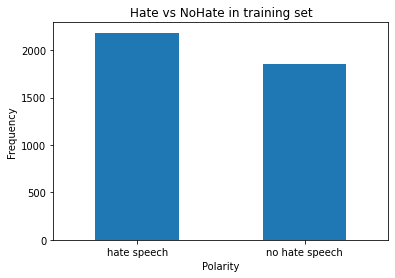

In [3]:
import matplotlib.pyplot as plt

def harry_plotter(df,string, strang):
    frequencies = df[string].value_counts()
    print(frequencies)
    ax = frequencies.plot(kind='bar')
    ax.set_xlabel('Polarity')
    ax.set_ylabel('Frequency')
    ax.set_title(strang)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
harry_plotter(training_data, "Label", "Hate vs NoHate in training set")
#harry_plotter(test_data, "Label", "Hate vs NoHate in test set")

CNN MODEL

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Embedding, Conv1D, Input, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Embedding, Conv2D, Conv1D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from PIL import Image


max_features = 20000
embedding_dim = 32
sequence_length = 40
image_height = 128
image_width = 128
image_channels = 3

# Assuming you have a pandas DataFrame with 'text', 'label', and 'sample' columns for training and test sets
train_df = training_data

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['Text'])

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['Text'])

# Pad sequences to a fixed length
train_data_text = pad_sequences(train_sequences, maxlen=sequence_length)

# Convert labels to one-hot encoding
train_labels = pd.get_dummies(train_df['Label']).values

# Load and preprocess the image data
def load_image(sample_id):
    image_path = f'./training_img/{sample_id}.jpg'
    image = Image.open(image_path)
    image = image.resize((image_width, image_height))
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

train_data_image = np.array([load_image(sample_id) for sample_id in train_df['Sample']])

# Split the training set into train and validation sets
train_data_text, val_data_text, train_data_image, val_data_image, train_labels, val_labels = train_test_split(
    train_data_text, train_data_image, train_labels, test_size=0.2, random_state=42
)

# Data augmentation for images
image_data_generator = ImageDataGenerator(
    rotation_range=10,  # Rotate the image randomly by a maximum of 10 degrees
    width_shift_range=0.1,  # Shift the image horizontally by a maximum of 10% of the width
    height_shift_range=0.1,  # Shift the image vertically by a maximum of 10% of the height
    shear_range=0.1,  # Apply shear transformation with a maximum of 10% intensity
    zoom_range=0.1,  # Zoom into the image by a maximum of 10%
    horizontal_flip=True  # Flip the image horizontally randomly
)


# List to store augmented images
augmented_images = []
augmented_labels = []

# Apply data augmentation to each image sample
for image_array, label in zip(train_data_image, train_labels):
    for _ in range(10):
        augmented_images.append(image_data_generator.random_transform(image_array))
        augmented_labels.append(label)

# Convert augmented images and labels to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate original and augmented images
train_data_image = np.concatenate([train_data_image, augmented_images], axis=0)
train_labels = np.concatenate([train_labels, augmented_labels], axis=0)

# Process text input
input_text = Input(shape=(sequence_length,))
embedding = Embedding(max_features + 1, embedding_dim, input_length=sequence_length,
                      embeddings_regularizer=regularizers.l2(0.0005))(input_text)
conv_text = Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.0005),
                   bias_regularizer=regularizers.l2(0.0005))(embedding)
flatten_text = Flatten()(conv_text)

# Process image input
input_image = Input(shape=(image_height, image_width, image_channels))
conv1 = Conv2D(64, (3, 3), activation='relu')(input_image)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(128, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
flatten_image = Flatten()(maxpool2)

# Concatenate image and text features
concatenated = concatenate([flatten_image, flatten_text])

# Batch normalization
batch_norm = BatchNormalization()(concatenated)

# Dense layers for classification
dense1 = Dense(32, activation='relu',
               kernel_regularizer=regularizers.l2(0.001),
               bias_regularizer=regularizers.l2(0.001))(batch_norm)
dropout_dense = Dropout(0.5)(dense1)
output = Dense(2, activation='sigmoid',
               kernel_regularizer=regularizers.l2(0.001),
               bias_regularizer=regularizers.l2(0.001))(dropout_dense)

# Create the model
model = Model(inputs=[input_image, input_text], outputs=output)
model.summary()

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='Nadam',
              metrics=["CategoricalAccuracy"])


# Train the model
epochs = 5
history = model.fit([train_data_image, train_data_text], train_labels,
                    validation_data=([val_data_image, val_data_text], val_labels),
                    epochs=epochs, batch_size=32)

# Calculate F1 score on the training set
train_predictions = model.predict([train_data_image, train_data_text])
train_predictions = np.argmax(train_predictions, axis=1)
train_true_labels = np.argmax(train_labels, axis=1)
train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
print(f"Train F1 score: {train_f1}")

# Extract the training loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training loss and validation loss
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

MemoryError: Unable to allocate 11.8 GiB for an array with shape (32340, 128, 128, 3) and data type float64

In [30]:
# Load and preprocess the image data
def load_image_test(sample_id):
    image_path = f'./test_img/{sample_id}.jpg'
    image = Image.open(image_path)
    image = image.resize((image_width, image_height))
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Assuming you have a pandas DataFrame with 'Text' column for the test set
test_df = test_data

# Tokenize the text data
test_sequences = tokenizer.texts_to_sequences(test_df['Text'])

# Pad sequences to a fixed length
test_data_text = pad_sequences(test_sequences, maxlen=sequence_length)

# Process image input
test_data_image = np.array([load_image_test(sample_id) for sample_id in test_df['Sample']])

# Make predictions with both text and image data
test_predictions = model.predict([test_data_image, test_data_text])
test_predictions = np.argmax(test_predictions, axis=1)

predictions_dict = {sample_id: prediction for sample_id, prediction in zip(test_df['Sample'], test_predictions)}

14/14 [==============================] - 19s 1s/step


In [31]:
print(predictions_dict)

{'10113': 0, '10165': 1, '10287': 1, '10443': 0, '10532': 0, '10708': 0, '10760': 1, '11066': 0, '11105': 0, '11224': 1, '11531': 0, '11607': 0, '12073': 1, '12129': 1, '12207': 0, '12515': 0, '12539': 0, '12641': 0, '12733': 1, '12799': 0, '12847': 0, '12886': 1, '12947': 0, '13300': 1, '13593': 1, '13740': 1, '14208': 0, '14269': 1, '14408': 0, '14445': 1, '14828': 1, '14891': 0, '15022': 1, '15256': 0, '15673': 0, '15873': 0, '16114': 0, '16173': 1, '16478': 1, '16514': 1, '16751': 0, '17024': 1, '17078': 0, '17223': 0, '17516': 1, '17590': 0, '17700': 0, '17930': 1, '18381': 0, '18382': 0, '18797': 0, '19000': 1, '19054': 1, '19344': 1, '19438': 1, '19499': 1, '19999': 1, '20095': 0, '20113': 1, '20425': 0, '20496': 1, '20534': 1, '20586': 0, '21069': 1, '21300': 0, '21529': 0, '21659': 0, '22011': 0, '22155': 1, '22171': 0, '22186': 0, '22700': 0, '22764': 0, '22798': 1, '22935': 1, '23204': 0, '23244': 0, '23635': 0, '23784': 0, '24189': 1, '24619': 0, '24639': 0, '24668': 0, '24

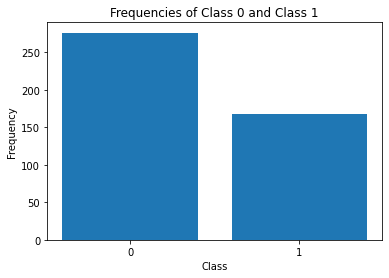

In [32]:
import matplotlib.pyplot as plt

# Count the frequencies of 0s and 1s in the predictions dictionary
freq_0 = sum(value == 0 for value in predictions_dict.values())
freq_1 = sum(value == 1 for value in predictions_dict.values())

# Plot the frequencies
labels = ['0', '1']
frequencies = [freq_0, freq_1]

plt.bar(labels, frequencies)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequencies of Class 0 and Class 1')
plt.show()

In [33]:
indexes = [int(mamada) for mamada in list(predictions_dict.keys())]
no_sorted = indexes
indexes.sort()

for i in range(len(no_sorted)):
    if no_sorted[i] == indexes[i]:
        ola = 0
    else:
        print("FEO")

predictions_dict_sorted = {}
for index in indexes:
    predictions_dict_sorted[str(index)] = predictions_dict[str(index)]
    
index_list = list(predictions_dict_sorted.keys())

In [34]:
import json

jason = open('submission.json', 'w')
for i in range(len(index_list)-1):
    jason.write('{"index": '+ str(index_list[i])+ ', "prediction": '+ str(predictions_dict_sorted[index_list[i]])+ "}")
    jason.write('\n')
jason.write('{"index": '+ str(index_list[-1])+ ', "prediction": '+ str(predictions_dict_sorted[index_list[-1]])+ "}")
jason.close()

In [27]:
#Trampitas por si son necesarias:

import re

jason = open('submission.json', 'r')
lineas = jason.readlines()
jason.close()

leneas = []
for liña in lineas:
    lañea = liña.split(",")
    leñea = lañea[0]+"," + re.sub(r'([01])', lambda m: '0' if m.group(1) == '1' else '1', lañea[1])
    leneas.append(leñea)
    
    
jeson = open('submission.json', 'w')
for i in range(len(leneas)-1):
    jeson.write(leneas[i])
    #jeson.write('\n')
jeson.write(leneas[-1])
jeson.close()